<a href="https://colab.research.google.com/github/gblasd/DataScience/blob/BDCC/04_TCognitiveAndBigData/notebooks/01__Intro_a_deep_learning_(regresi%C3%B3n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning on tabular data (regression)

## Preparación de ambiente

### Carga de módulos

In [16]:
!pip install -U -q cufflinks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00


In [22]:
# Data wrangling
import numpy as np
import pandas as pd

# Plotting
import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from keras import Input
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Model performance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

# Environment setup
cf.set_config_file(offline=True, theme="solar")
pd.set_option("display.max_columns", 50)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Wrangling

In [3]:
df = pd.read_csv("/content/drive/MyDrive/DataScience/data/spotify_tracks.csv")

In [4]:
df.sample(5)

,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language
55329,6tcYpyw4rr5mTqDidS29IY,Paradise (feat. *NSYNC),"Justin Timberlake, *NSYNC",2024,56,https://i.scdn.co/image/ab67616d0000b273aac85c...,Everything I Thought It Was,0.622000,0.517,266827.0,0.5410,0.000,3.0,0.129,-7.501,1.0,0.0303,81.982,4.0,0.1890,https://open.spotify.com/track/6tcYpyw4rr5mTqD...,English
25485,4whG6kcgqybA84DBbgwQkQ,Push Up On Me - Moto Blanco,"Rihanna, Moto Blanco",2009,20,https://i.scdn.co/image/ab67616d0000b273d38fac...,Good Girl Gone Bad: The Remixes,0.000033,0.632,208747.0,0.9530,0.912,1.0,0.262,-4.777,1.0,0.0376,128.007,4.0,0.7950,https://open.spotify.com/track/4whG6kcgqybA84D...,English
44733,5hCGCAnO0jjJn8qlwdZpNF,It's Destroyed / Back To The Girlfriend / It E...,Alan Silvestri,1990,7,https://i.scdn.co/image/ab67616d0000b273e3484a...,Back To The Future Part III: 25th Anniversary ...,0.202000,0.144,221133.0,0.0429,0.234,7.0,0.304,-27.814,1.0,0.0367,72.569,4.0,0.0365,https://open.spotify.com/track/5hCGCAnO0jjJn8q...,English
25336,2f5PEKVrNEHL1X0dtMNgYu,Farewell,Rihanna,2011,39,https://i.scdn.co/image/ab67616d0000b2731c5eac...,Talk That Talk,0.080500,0.516,256307.0,0.8570,0.000,7.0,0.149,-4.559,1.0,0.1110,80.004,4.0,0.5060,https://open.spotify.com/track/2f5PEKVrNEHL1X0...,English
47611,5hP5gVKiUfeQ8HuI4Lx6az,"Karuppu Nerathazhagi (From ""Komban"")","G. V. Prakash, Velmurugan, Maalavika Sundar",2024,0,https://i.scdn.co/image/ab67616d0000b27336175d...,Valentine's Love Voltage,0.382000,0.628,271733.0,0.7630,0.000,10.0,0.116,-6.959,0.0,0.2640,93.695,4.0,0.8880,https://open.spotify.com/track/5hP5gVKiUfeQ8Hu...,English


### Dicionario de datos

* **track_id:** ID de Spotify para la pista.
* **track_name:** Nombre de la pista.
* **artist_name:** Nombres de los artistas que interpretan la pista, separados por comas si hay varios artistas.
* **year:** Año de lanzamiento de la pista.
* **popularity:** Valor entre 0 y 100 que indica la popularidad de una pista según las reproducciones y la actualidad.
* **artwork_url:** URL de la carátula del álbum o de la pista.
* **album_name:** El álbum en el que aparece la pista.
* **acousticness:** Medida de confianza de 0.0 a 1.0 de si la pista es acústica.
* **danceability:** Medida de cuán adecuada es una pista para bailar (0.0 = menos bailable, 1.0 = más bailable).
* **duration_ms:** Duración de la pista en milisegundos.
* **energy:** Medida perceptual de 0.0 a 1.0 de intensidad y actividad.
* **key:** Tonalidad musical de la pista, utilizando la notación estándar de clase de tono (por ejemplo, 0 = Do, 1 = Do♯/Re♭).
* **liveness:** Medida de la probabilidad de que la pista se haya grabado en directo (valores más altos indican interpretaciones en directo).
* **loudness:** Sonoridad general de la pista en decibelios (dB).
* **mode:** Indica la modalidad de la pista (1 = mayor, 0 = menor).
* **speechiness:** Mide la presencia de palabras habladas en una pista (más cerca de 1.0 indica un contenido más parecido al habla).
* **tempo:** Tempo estimado de la pista en pulsaciones por minuto (BPM).
* **time_signature:** Número de tiempos por compás, que van de 3 a 7.
* **valence:** Medida de 0.0 a 1.0 que indica la positividad musical de la pista (valores más altos son más felices).
* **track_url:** URL de Spotify para la pista.
* **language:** Idioma de la pista (inglés, tamil, hindi, telugu, malayalam, coreano).

### EDA

In [5]:
df.describe()

,year,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,62317.000000,62317.000000,62317.000000,62317.000000,6.231700e+04,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000,62317.000000
mean,2014.425935,15.358361,0.362292,0.596807,2.425270e+05,0.602496,0.146215,5.101658,0.194143,-65.103433,0.586052,0.087722,117.931247,3.857086,0.495226
std,9.645113,18.626908,0.314609,0.186209,1.129999e+05,0.246144,0.307804,3.553469,0.172030,2369.051478,0.493682,0.115150,28.509459,0.502660,0.264787
min,1971.000000,0.000000,-1.000000,-1.000000,5.000000e+03,-1.000000,-1.000000,-1.000000,-1.000000,-100000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2011.000000,0.000000,0.067100,0.497000,1.921600e+05,0.440000,0.000000,2.000000,0.093200,-10.727000,0.000000,0.036700,95.942000,4.000000,0.292000
50%,2017.000000,7.000000,0.286000,0.631000,2.362670e+05,0.639000,0.000025,5.000000,0.125000,-7.506000,1.000000,0.048900,117.991000,4.000000,0.507000
75%,2022.000000,26.000000,0.632000,0.730000,2.862400e+05,0.803000,0.015200,8.000000,0.243000,-5.456000,1.000000,0.089100,135.081000,4.000000,0.710000
max,2024.000000,93.000000,0.996000,0.986000,4.581483e+06,1.000000,0.999000,11.000000,0.998000,1.233000,1.000000,0.959000,239.970000,5.000000,0.995000


In [6]:
df = df[df["year"]>=2020]

In [7]:
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness",
            "loudness", "speechiness", "tempo", "valence", ]
target = "popularity"

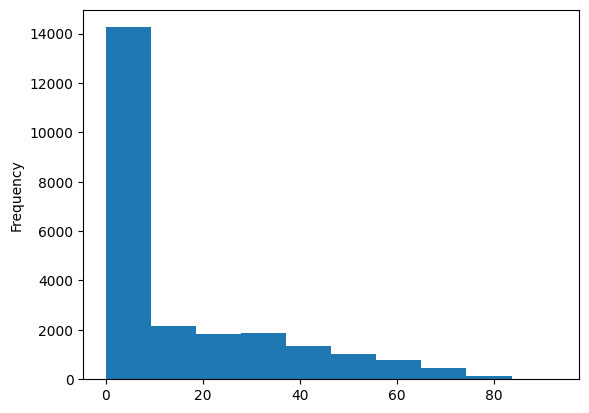

In [23]:
df["popularity"].plot(kind="hist")
plt.show()

In [24]:
X = df[features]

In [25]:
y = df[[target]]

In [26]:
sc = MinMaxScaler()

In [27]:
Xs = pd.DataFrame(data=sc.fit_transform(X), columns=features, index=X.index)

In [28]:
X[features].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,23890.000000,23890.000000,2.389000e+04,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000
mean,0.339431,0.601171,2.186950e+05,0.595982,0.134112,0.189889,-121.730273,0.098095,118.136609,0.470900
std,0.311647,0.182307,1.040325e+05,0.245815,0.302081,0.163022,3359.696203,0.148961,28.732011,0.255014
min,-1.000000,-1.000000,5.000000e+03,-1.000000,-1.000000,-1.000000,-100000.000000,-1.000000,-1.000000,-1.000000
25%,0.056100,0.510000,1.796288e+05,0.436000,0.000000,0.093800,-10.295000,0.036700,96.131000,0.285000
50%,0.244000,0.634000,2.121565e+05,0.635000,0.000006,0.125000,-7.224000,0.048750,117.947000,0.473000
75%,0.596000,0.727000,2.513908e+05,0.790000,0.005052,0.241000,-5.343000,0.093800,136.023000,0.671000
max,0.996000,0.986000,3.546751e+06,1.000000,0.999000,0.993000,1.233000,0.959000,230.210000,0.989000


In [29]:
Xs[features].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000,23890.000000
mean,0.671057,0.806229,0.060336,0.797991,0.567339,0.597034,0.998770,0.560539,0.515274,0.739517
std,0.156136,0.091796,0.029373,0.122908,0.151116,0.081797,0.033597,0.076039,0.124268,0.128212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.529108,0.760322,0.049306,0.718000,0.500250,0.548821,0.999885,0.529199,0.420099,0.646053
50%,0.623246,0.822759,0.058490,0.817500,0.500253,0.564476,0.999915,0.535350,0.514454,0.740573
75%,0.799599,0.869587,0.069567,0.895000,0.502778,0.622679,0.999934,0.558346,0.592634,0.840121
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
Xs.sample(5)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
20515,0.519890,0.862538,0.062792,0.8380,0.500250,0.579027,0.999933,0.524247,0.432715,0.865259
24055,0.640782,0.821249,0.171674,0.7610,0.500250,0.545660,0.999901,0.525881,0.406557,0.609854
53702,0.524248,0.902820,0.062007,0.8085,0.502261,0.584546,0.999944,0.549566,0.587816,0.712921
55663,0.888778,0.635952,0.059580,0.7250,0.500269,0.778726,0.999905,0.529301,0.344163,0.692308
54163,0.889780,0.731621,0.086511,0.6610,0.955478,0.543603,0.999884,0.531394,0.472540,0.772247


In [31]:
sc_y = MinMaxScaler()

In [32]:
ys = pd.DataFrame(data=sc_y.fit_transform(y), columns=y.columns, index=y.index)

In [33]:
y.describe()

,popularity
count,23890.000000
mean,14.909627
std,19.729302
min,0.000000
25%,0.000000
50%,4.000000
75%,26.000000
max,93.000000


In [34]:
ys.describe()

,popularity
count,23890.000000
mean,0.160319
std,0.212143
min,0.000000
25%,0.000000
50%,0.043011
75%,0.279570
max,1.000000


### Train-test split

In [35]:
Xt, Xv, yt, yv = train_test_split(Xs, ys)

## Modelado

### Base

In [36]:
model = Sequential()

### Capa de entrada

In [37]:
Xt.shape

(17917, 10)

In [38]:
Input?

In [39]:
model.add(Input(shape=(Xt.shape[1],)))

### Capas ocultas

In [40]:
model.add(Dense(64, activation='tanh'),)
model.add(Dense(128, activation='tanh'),)
model.add(Dense(256, activation='tanh'),)
model.add(Dense(128, activation='tanh'),)
model.add(Dense(64, activation='tanh'),)
model.add(Dense(1))

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,265 (325.25 KB)

 Trainable params: 83,265 (325.25 KB)

 Non-trainable params: 0 (0.00 B)

### Métricas de performance

In [42]:
kmetrics = [
    RootMeanSquaredError(name='rms'),
    MeanAbsoluteError(name='mae'),
    MeanAbsolutePercentageError(name='mape'),
]

### Configuración de entrenamiento

In [43]:
model.compile(loss = "mean_squared_error", optimizer = "sgd", metrics=kmetrics)

In [44]:
y_real = 0.2

In [45]:
y_hat = .4

In [46]:
(y_real-y_hat)**2

0.04000000000000001

### Entrenamiento

In [47]:
model.fit(x = Xt, y=yt, epochs = 1_000, batch_size = 5_000, validation_data=(Xv, yv))

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.0809 - mae: 0.2213 - mape: 44891964.0000 - rms: 0.2826 - val_loss: 0.0458 - val_mae: 0.1782 - val_mape: 55423272.0000 - val_rms: 0.2140
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0466 - mae: 0.1767 - mape: 52980832.0000 - rms: 0.2159 - val_loss: 0.0455 - val_mae: 0.1752 - val_mape: 52791980.0000 - val_rms: 0.2132
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0475 - mae: 0.1776 - mape: 51460000.0000 - rms: 0.2179 - val_loss: 0.0453 - val_mae: 0.1757 - val_mape: 53592132.0000 - val_rms: 0.2129
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0464 - mae: 0.1759 - mape: 52256628.0000 - rms: 0.2154 - val_loss: 0.0451 - val_mae: 0.1749 - val_mape: 53042756.0000 - val_rms: 0.2124
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0465 - mae: 0.1758 - mape: 52262084.0000 - rms: 0.2156 - val_loss: 0.0450 - val_mae: 0.1746 - val_mape: 52974880.0000 - val_rms: 0.2121
Epoch 6/10

$\displaystyle{\frac{|y-\hat{y}|}{y}}$

### Análisis de resultados

In [48]:
dc_history = model.history.history

In [49]:
loss = pd.DataFrame(dc_history)

In [50]:
loss

,loss,mae,mape,rms,val_loss,val_mae,val_mape,val_rms
0,0.066914,0.203612,48336996.0,0.258678,0.045792,0.178165,55423272.0,0.213991
1,0.046936,0.176845,52158388.0,0.216647,0.045454,0.175182,52791980.0,0.213199
2,0.046684,0.176224,51843120.0,0.216066,0.045310,0.175720,53592132.0,0.212862
3,0.046538,0.175880,51797392.0,0.215727,0.045133,0.174927,53042756.0,0.212445
4,0.046316,0.175615,51853632.0,0.215210,0.044991,0.174641,52974880.0,0.212111
...,...,...,...,...,...,...,...,...
995,0.042806,0.166582,47376384.0,0.206895,0.042138,0.168147,50359332.0,0.205276
996,0.042811,0.166914,47709152.0,0.206909,0.042123,0.167886,50088468.0,0.205240
997,0.042801,0.166933,47735212.0,0.206885,0.042111,0.167632,49824480.0,0.205209
998,0.042800,0.166941,47738676.0,0.206881,0.042121,0.167842,50043524.0,0.205234


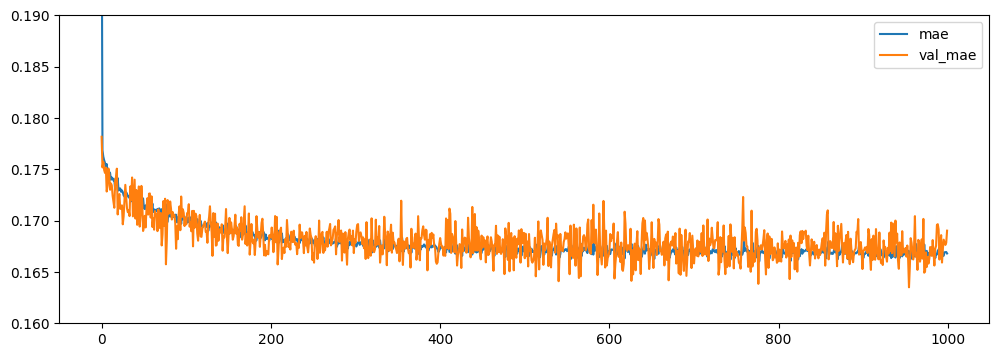

In [79]:
# loss.drop([0, 1, 2])[["mae", "val_mae"]].plot(kind="scatter")
loss[["mae", "val_mae"]].plot(kind="line", figsize=(12, 4), ylim=(0.16, 0.19))
plt.show()

### Predicción

In [80]:
yt_pred = model.predict(Xt)

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [81]:
yt_pred

array([[0.24445781],
       [0.0880609 ],
       [0.22388718],
       ...,
       [0.25016218],
       [0.1672308 ],
       [0.17316142]], dtype=float32)

In [82]:
yt_pred = sc_y.inverse_transform(yt_pred)

In [83]:
yt_pred

array([[22.734577 ],
       [ 8.189664 ],
       [20.821507 ],
       ...,
       [23.265083 ],
       [15.5524645],
       [16.104012 ]], dtype=float32)

In [84]:
yt_pred = yt_pred.round()

In [85]:
r2_score(yt, yt_pred)

-5667.638671875

In [86]:
yv_pred = model.predict(Xv)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [87]:
yv_pred = sc_y.inverse_transform(yv_pred)

In [88]:
yv_pred

array([[17.207441],
       [12.291228],
       [17.277615],
       ...,
       [14.021306],
       [17.455769],
       [20.773691]], dtype=float32)

In [89]:
r2_score(yv, yv_pred.round())

-5868.1708984375

In [90]:
mean_absolute_error(yv, yv_pred.round())

15.474709510803223

### Plan B

#### Discretización de la target

In [91]:
df[target+"_c"] = pd.cut(y[target], bins=np.linspace(0, 100, 3), include_lowest=True)

In [92]:
le = LabelEncoder()

#### Train-test split

In [93]:
Xt, Xv, yt, yv = train_test_split(Xs, df[target+"_c"], random_state=123)

#### Oversampling

In [94]:
aux = pd.concat([Xt, yt], axis=1)

In [95]:
aux

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity_c
30390,0.501052,0.775932,0.058781,0.94100,0.933467,0.813347,0.999948,0.551353,0.696514,0.837104,"(-0.001, 50.0]"
7715,0.971944,0.690332,0.030042,0.53865,0.935468,0.582037,0.999817,0.527208,0.421357,0.525440,"(-0.001, 50.0]"
15998,0.580661,0.862034,0.058150,0.82950,0.506703,0.540943,0.999924,0.537928,0.277012,0.776772,"(-0.001, 50.0]"
30736,0.546042,0.910373,0.054508,0.95150,0.500250,0.542699,0.999966,0.547677,0.523524,0.966315,"(50.0, 100.0]"
12639,0.625251,0.920443,0.049411,0.82600,0.500256,0.699950,0.999910,0.573252,0.653090,0.985420,"(-0.001, 50.0]"
...,...,...,...,...,...,...,...,...,...,...,...
43084,0.931864,0.885700,0.064270,0.70050,0.500250,0.651781,0.999898,0.642675,0.437377,0.792358,"(-0.001, 50.0]"
59424,0.733968,0.723061,0.017081,0.63400,0.944972,0.555444,0.999739,0.527616,0.783059,0.639517,"(-0.001, 50.0]"
48366,0.521643,0.648540,0.078297,0.72200,0.942971,0.551932,0.999855,0.534712,0.562843,0.522775,"(-0.001, 50.0]"
43858,0.502234,0.877140,0.033729,0.99350,0.969485,0.664325,0.999968,0.587034,0.415125,0.668175,"(-0.001, 50.0]"


In [96]:
aux["popularity_c"].value_counts(True)

,proportion
popularity_c,
"(-0.001, 50.0]",0.916671
"(50.0, 100.0]",0.083329


In [97]:
max_size = aux["popularity_c"].value_counts().max()

In [98]:
max_size

16424

In [99]:
lst = [aux]
for class_index, group in aux.groupby("popularity_c"):
    lst.append(group.sample(max_size-len(group), replace=True))
aux = pd.concat(lst)

/tmp/ipython-input-2379022240.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [100]:
aux["popularity_c"].value_counts(True)

,proportion
popularity_c,
"(-0.001, 50.0]",0.5
"(50.0, 100.0]",0.5


#### Preparación de conjuntos

In [101]:
Xt = aux[features]
yt = aux["popularity_c"]

In [102]:
le = LabelEncoder()

In [103]:
yt = to_categorical(le.fit_transform(yt))

#### Construcción de la red

In [104]:
model1 = Sequential()
model1.add(Input(shape=(Xt.shape[1],)))
model1.add(Dense(256, activation="relu"))
model1.add(Dense(len(le.classes_), activation='softmax'))

In [105]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [106]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,330 (13.01 KB)

 Trainable params: 3,330 (13.01 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [107]:
model1.fit(x = Xt, y=yt, epochs = 1_500, batch_size = 5_000, validation_data=(Xv, to_categorical(le.transform(yv))))

Epoch 1/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4691 - loss: 0.6958 - val_accuracy: 0.7817 - val_loss: 0.6733
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5689 - loss: 0.6849 - val_accuracy: 0.3692 - val_loss: 0.7077
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6016 - loss: 0.6780 - val_accuracy: 0.5895 - val_loss: 0.6607
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6164 - loss: 0.6718 - val_accuracy: 0.5337 - val_loss: 0.6658
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6162 - loss: 0.6664 - val_accuracy: 0.5143 - val_loss: 0.6678
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6132 - loss: 0.6619 - val_accuracy: 0.5088 - val_loss: 0.6677
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6143 - loss: 0.6572 - val_accuracy: 0.5250 - val_loss: 0.6554
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6168 - loss: 0.6525 - val_accuracy: 0.5262 - v

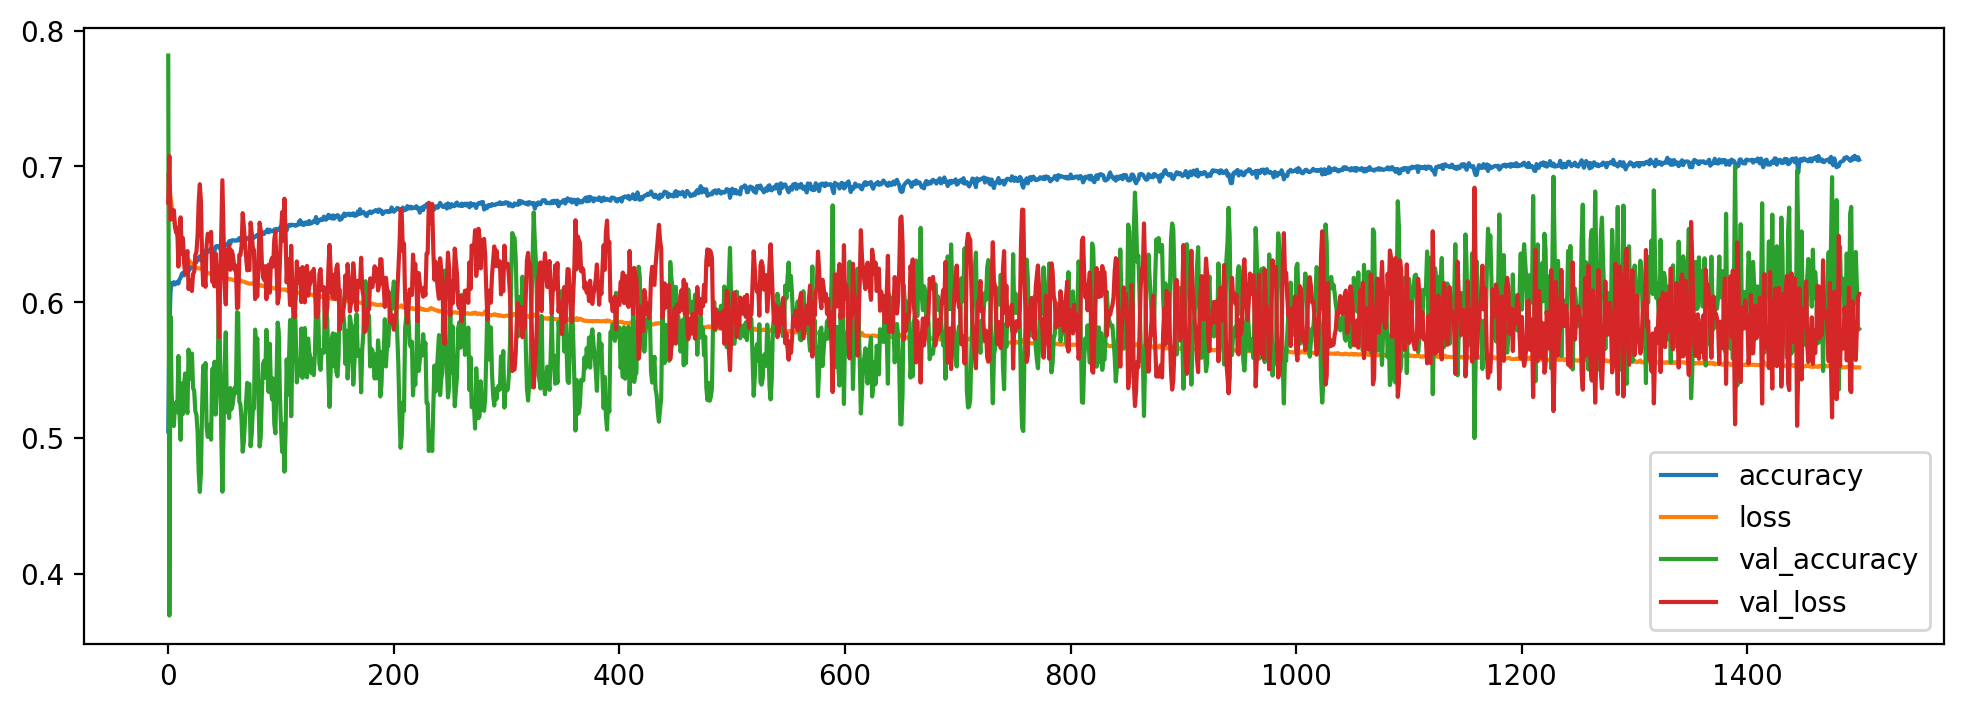

In [112]:
# pd.DataFrame(model1.history.history).iplot()
pd.DataFrame(model1.history.history).plot(figsize=(12, 4))
plt.show()

#### Evaluación de modelo

In [113]:
loss, acc = model1.evaluate(Xt, yt)

1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6266 - loss: 0.5844


In [114]:
acc

0.7088711857795715

In [115]:
y_pred = model1.predict(Xv)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)
y_pred = pd.Series(y_pred, dtype=str)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [116]:
accuracy_score(y_true=yv.astype(str), y_pred=y_pred)

0.5802779172944919

#### Preservación de modelo

In [ ]:
model.save('./deep_regression.keras')